# Open Street Maps Distance Covariates for Kenya #

#### Libraries ####

In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import rasterio.mask
import rasterio.plot
import requests
import folium
from shapely.geometry import LineString
from shapely.geometry import Point
from pathlib import Path
import seaborn as sns
from scipy.ndimage import distance_transform_edt

## Custom Distance Algorithm ##

## Custom Utility Function ##

In [5]:
# I already have a utility function for punching admin size holes out of rasters
def mask_admin(in_path: Path, admin_path: Path, out_path: Path):
    with rasterio.open(in_path) as src:
        admin = gpd.read_file(admin_path).to_crs(src.crs)
        kwargs = {
            'all_touched': True,
            'nodata': np.nan,
        }
        out_image, out_transform = rasterio.mask.mask(
            src, 
            admin.geometry.tolist(),
            **kwargs        
        )
        out_meta = src.meta

    out_meta.update({"driver": "GTiff",
                     "nodata": np.nan,
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    with rasterio.open(out_path, "w", **out_meta) as dest:
        dest.write(out_image)

# Custom Function  - Rasterizes GDF Geometry and Returns Indices #

In [6]:
def rasterize_and_get_indices(gdf, out_shape, transform):
    # Rasterize the GeoDataFrame
    rasterized = rasterio.features.rasterize(
        [(geom, 1) for geom in gdf.geometry],
        out_shape=out_shape,
        transform=transform,
        fill=0,
        all_touched=True,
        dtype=rasterio.uint8
    )

    # Get indices where rasterized data is not empty or 0
    indices_ones = np.where(rasterized != 0)
    indices_list = np.array(list(zip(indices_ones[1], indices_ones[0])))
    
    return rasterized, indices_list

# Read in Kenya Data #

In [7]:
# Bulding Density Data
building_density_path = '/mnt/team/rapidresponse/pub/population/data/03-processed-data/building-layers/KEN/_archive/2020_q2/full.tif'
with rasterio.open(building_density_path) as src:
    # We don't need anything from this dataset except the metadata about 
    # it's shape and resolution.
    meta = src.meta
    kenya_shape = src.shape
    
# Transform Data
transform = meta['transform']
# Out metadata is exactly the same as our in metadata.
out_meta = meta.copy()
target_crs = out_meta['crs']

# Resolution Data
resolution = transform.a  # You can access matrix elements by a,b,c,d,etc, just check you're getting the value you expect.
x_offset = transform.xoff
y_offset = transform.yoff

# Get the width and height in pixels from the metadata
width = meta['width']
height = meta['height']

# Make arrays of [0, 1, ..., width] and [0, 1, ..., height]
x_ind = np.arange(width)  # Just like python's `range` function, but makes a numpy array, which we can do vector math with.
y_ind = np.arange(height) 

# Here is the magic of numpy. We can write the same expressions and they'll
# work pretty much seamlessly across scalars and vectors and higher dimensional arrays
# (as long as the operations are well defined.
x = resolution * (x_ind + 1/2) + x_offset  # Makes an array where each element is now an x-coordinate of a centroid in our CRS
y = -resolution * (y_ind + 1/2) + y_offset

# Rivers and Lake Covariate #

In [8]:
natural_earth_river_path = '/mnt/team/rapidresponse/pub/population/data/01-raw-data/covariates/KEN/bodies-of-water/natural-earth/rivers-lakes/ne_10m_rivers_lake_centerlines.shp'

# Replace 'path_to_your_shapefile' with the actual path to your shapefile
ne_rivers_gdf = gpd.read_file(natural_earth_river_path)


ne_rivers_gdf = ne_rivers_gdf.to_crs(target_crs)

raster_river, ne_rivers_indices = rasterize_and_get_indices(ne_rivers_gdf, kenya_shape, transform)

In [9]:
# Swap 0s and 1s
raster_river = np.logical_not(raster_river).astype(int)

In [8]:
%%time
ne_river_out = distance_transform_edt(raster_river)

CPU times: user 1min 15s, sys: 8.68 s, total: 1min 24s
Wall time: 1min 24s


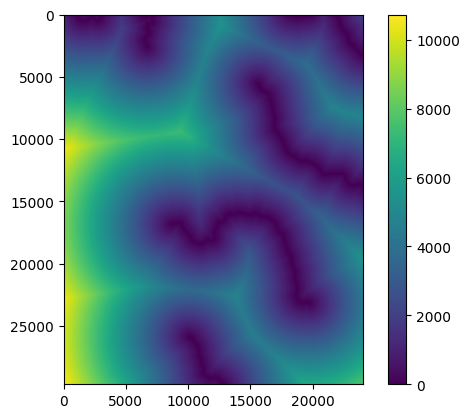

In [9]:
# Create a heatmap using Matplotlib
plt.imshow(ne_river_out, cmap='viridis')
# Add colorbar for reference
plt.colorbar()
# Show the plot
plt.show()

In [10]:
# Use Natural Earth Shape file as place holder
admin0_path = Path('/mnt/share/homes/mfiking/population/gis/population/kenya_admin_files/ken_admbnda_adm0_iebc_20191031.shp')

# Change the data type of the distance array to the same data type as out_meta
ne_river_out = ne_river_out.astype(out_meta['dtype'])

# Create path to store output
ne_river_out_path = '/mnt/share/homes/mfiking/population/gis/population/distance_covariates/natural_earth/water/rivers_lake_centers.tif'

# Generate meta data into out_path same meta data as out_meta
with rasterio.open(ne_river_out_path, "w", **out_meta) as dest:
    dest.write(ne_river_out.reshape((1, *ne_river_out.shape)))


# Just overwrite the file we wrote
mask_admin(ne_river_out_path, admin0_path, ne_river_out_path)

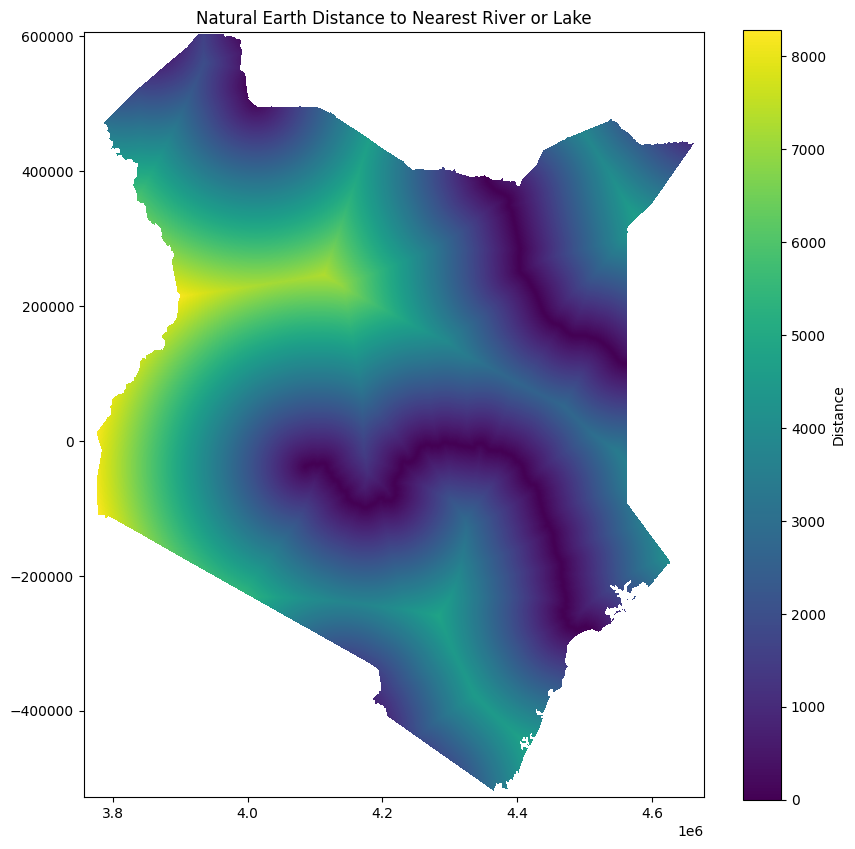

In [11]:
# Read the combined raster
with rasterio.open(ne_river_out_path) as src:
    combined_raster = src.read(1, masked=True)
    transform = src.transform
    crs = src.crs

# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(combined_raster, extent=(transform[2], transform[2] + transform[0]*combined_raster.shape[1],
                                   transform[5] + transform[4]*combined_raster.shape[0], transform[5]), cmap='viridis')

# Add a colorbar
cb = plt.colorbar()
cb.set_label('Distance')

# Set the title of the plot
plt.title('Natural Earth Distance to Nearest River or Lake')

plt.savefig('/mnt/share/homes/mfiking/population/gis/population/distance_covariates/natural_earth/water/plots/rivers_lake_centers.jpg', dpi=300, bbox_inches='tight')

plt.show()

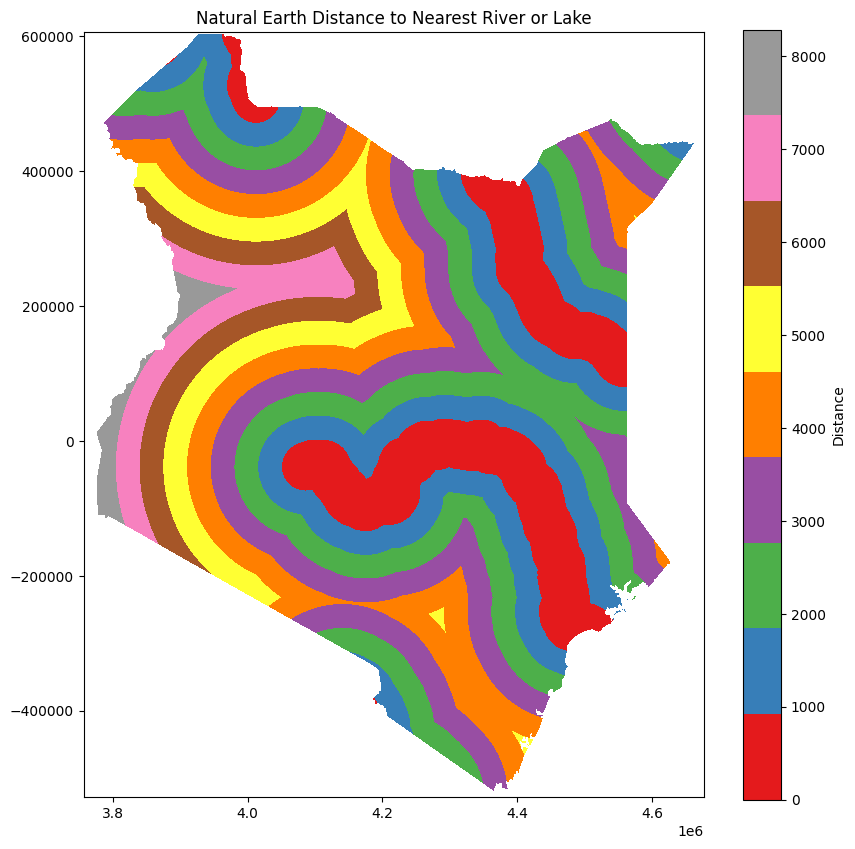

In [12]:
ne_river_out_path = '/mnt/share/homes/mfiking/population/gis/population/distance_covariates/natural_earth/water/rivers_lake_centers.tif'

# Read the combined raster
with rasterio.open(ne_river_out_path) as src:
    combined_raster = src.read(1, masked=True)
    transform = src.transform
    crs = src.crs

# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(combined_raster, extent=(transform[2], transform[2] + transform[0]*combined_raster.shape[1],
                                   transform[5] + transform[4]*combined_raster.shape[0], transform[5]), cmap='Set1')

# Add a colorbar
cb = plt.colorbar()
cb.set_label('Distance')

# Set the title of the plot
plt.title('Natural Earth Distance to Nearest River or Lake')
plt.show()


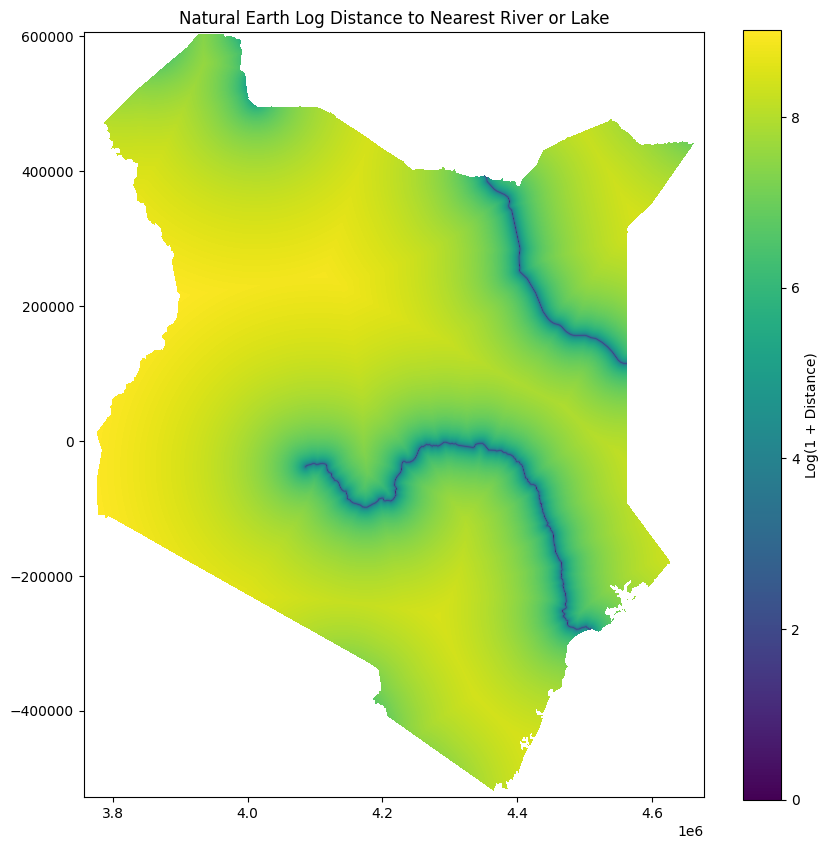

In [13]:
ne_river_out_path = '/mnt/share/homes/mfiking/population/gis/population/distance_covariates/natural_earth/water/rivers_lake_centers.tif'

# Log Plot
with rasterio.open(ne_river_out_path) as src:
    combined_raster = src.read(1, masked=True)
    transform = src.transform
    crs = src.crs
    
    # Apply the log transformation
    combined_raster = np.log(1 + combined_raster)
    
# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(combined_raster, extent=(transform[2], transform[2] + transform[0]*combined_raster.shape[1],
                                   transform[5] + transform[4]*combined_raster.shape[0], transform[5]), cmap='viridis')

# Add a colorbar
cb = plt.colorbar()
cb.set_label('Log(1 + Distance)')

# Set the title of the plot
plt.title('Natural Earth Log Distance to Nearest River or Lake')

plt.savefig('/mnt/share/homes/mfiking/population/gis/population/distance_covariates/natural_earth/water/plots/log_rivers_lake_centers.jpg', dpi=300, bbox_inches='tight')

plt.show()


# Coastline Covariate #

In [14]:
natural_earth_coastline_path = '/mnt/share/homes/mfiking/population/gis/population/test/ne_10m_coastlines/ne_10m_coastline.shp'

# Replace 'path_to_your_shapefile' with the actual path to your shapefile
coastline_gdf = gpd.read_file(natural_earth_coastline_path)


coastline_gdf = coastline_gdf.to_crs(target_crs)

raster_coastline, coastline_indices = rasterize_and_get_indices(coastline_gdf, kenya_shape, transform)
# Swap 0s and 1s
raster_coastline = np.logical_not(raster_coastline).astype(int)

In [15]:
%%time
coastline_out = distance_transform_edt(raster_coastline)

CPU times: user 1min 5s, sys: 9.87 s, total: 1min 14s
Wall time: 1min 14s


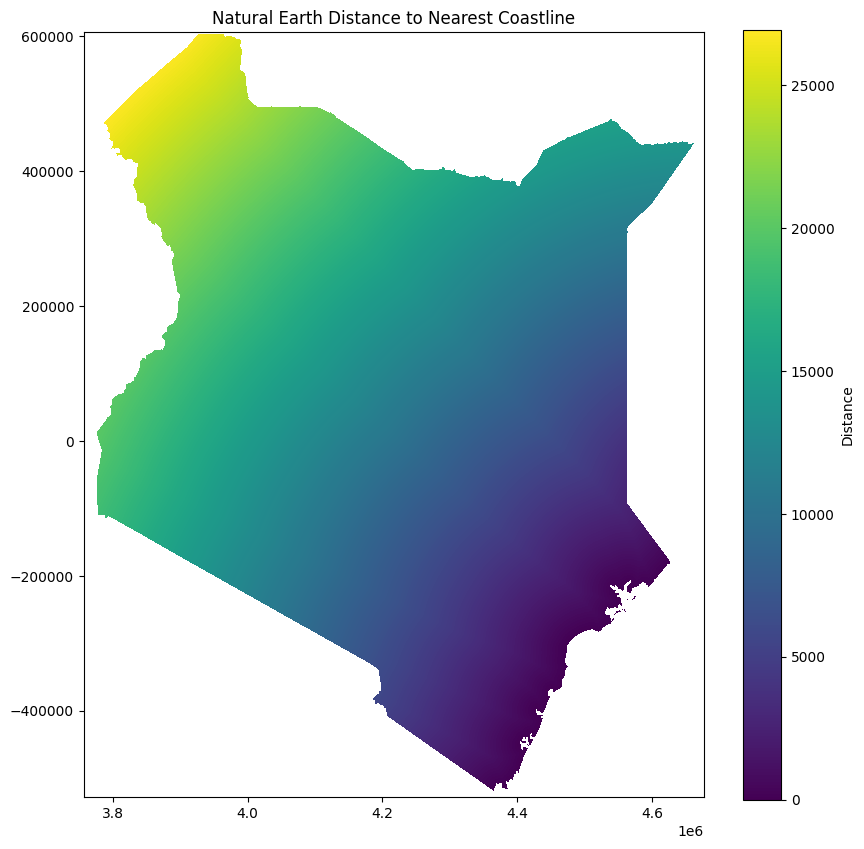

In [16]:
# Use Natural Earth Shape file as place holder
admin0_path = Path('/mnt/share/homes/mfiking/population/gis/population/kenya_admin_files/ken_admbnda_adm0_iebc_20191031.shp')

# Change the data type of the distance array to the same data type as out_meta
coastline_out = coastline_out.astype(out_meta['dtype'])

# Create path to store output
coastline_out_path = '/mnt/share/homes/mfiking/population/gis/population/distance_covariates/natural_earth/water/coastline.tif'

# Generate meta data into out_path same meta data as out_meta
with rasterio.open(coastline_out_path, "w", **out_meta) as dest:
    dest.write(coastline_out.reshape((1, *coastline_out.shape)))


# Just overwrite the file we wrote
mask_admin(coastline_out_path, admin0_path, coastline_out_path)

# Read the combined raster
with rasterio.open(coastline_out_path) as src:
    combined_raster = src.read(1, masked=True)
    transform = src.transform
    crs = src.crs

# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(combined_raster, extent=(transform[2], transform[2] + transform[0]*combined_raster.shape[1],
                                   transform[5] + transform[4]*combined_raster.shape[0], transform[5]), cmap='viridis')

# Add a colorbar
cb = plt.colorbar()
cb.set_label('Distance')

# Set the title of the plot
plt.title('Natural Earth Distance to Nearest Coastline')


plt.savefig('/mnt/share/homes/mfiking/population/gis/population/distance_covariates/natural_earth/water/plots/coastline.jpg', dpi=300, bbox_inches='tight')

plt.show()

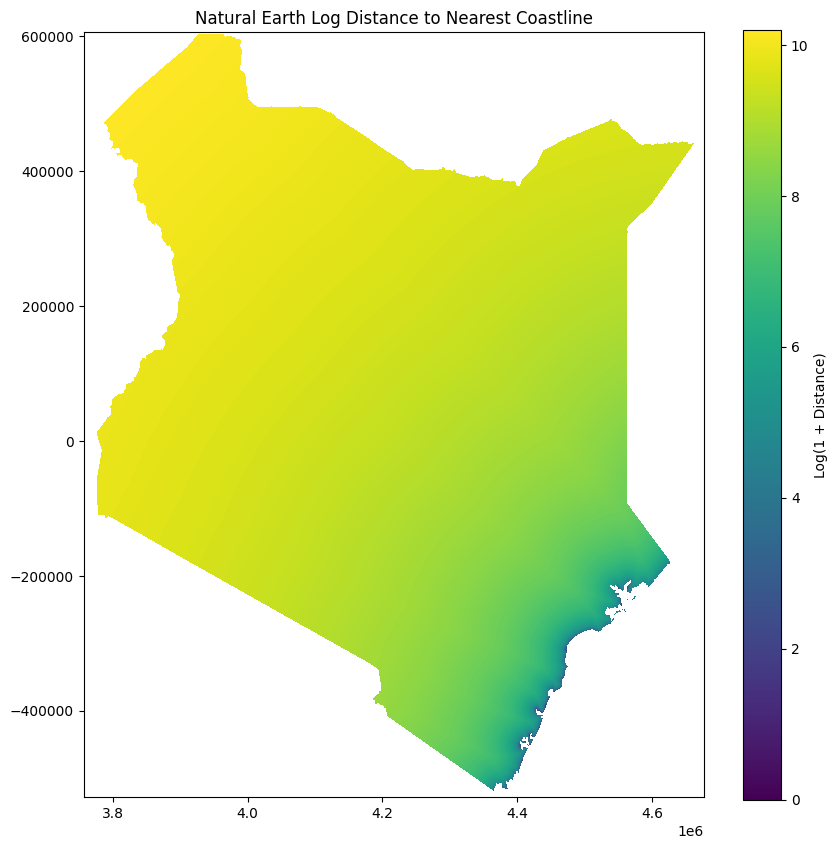

In [17]:
# Log Plot
with rasterio.open(coastline_out_path) as src:
    combined_raster = src.read(1, masked=True)
    transform = src.transform
    crs = src.crs
    
    # Apply the log transformation
    combined_raster = np.log(1 + combined_raster)
    
# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(combined_raster, extent=(transform[2], transform[2] + transform[0]*combined_raster.shape[1],
                                   transform[5] + transform[4]*combined_raster.shape[0], transform[5]), cmap='viridis')

# Add a colorbar
cb = plt.colorbar()
cb.set_label('Log(1 + Distance)')

# Set the title of the plot
plt.title('Natural Earth Log Distance to Nearest Coastline')

plt.savefig('/mnt/share/homes/mfiking/population/gis/population/distance_covariates/natural_earth/water/plots/log_coastline.jpg', dpi=300, bbox_inches='tight')

plt.show()

# Population Centers Covariate #

In [18]:
population_path = Path('/mnt/share/homes/mfiking/population/gis/population/kenya_cities/hotosm_ken_populated_places_points.shp')
population_data = gpd.read_file(population_path)

population_data = population_data.to_crs(target_crs)

## Cities ##

In [19]:
# Subset population center
city_gdf = population_data[population_data['place'].str.lower() == 'city']
# Get indices
city_raster, city_indices = rasterize_and_get_indices(city_gdf, kenya_shape, transform)

In [20]:
# Swap 0s and 1s
city_raster = np.logical_not(city_raster).astype(int)

In [21]:
%%time
city_out = distance_transform_edt(city_raster)

CPU times: user 58.8 s, sys: 13.8 s, total: 1min 12s
Wall time: 1min 12s


In [10]:
# %%time
# city_out = compute_min_distance(city_indices, (kenya_shape))

CPU times: user 27min 51s, sys: 54.7 s, total: 28min 46s
Wall time: 28min 39s


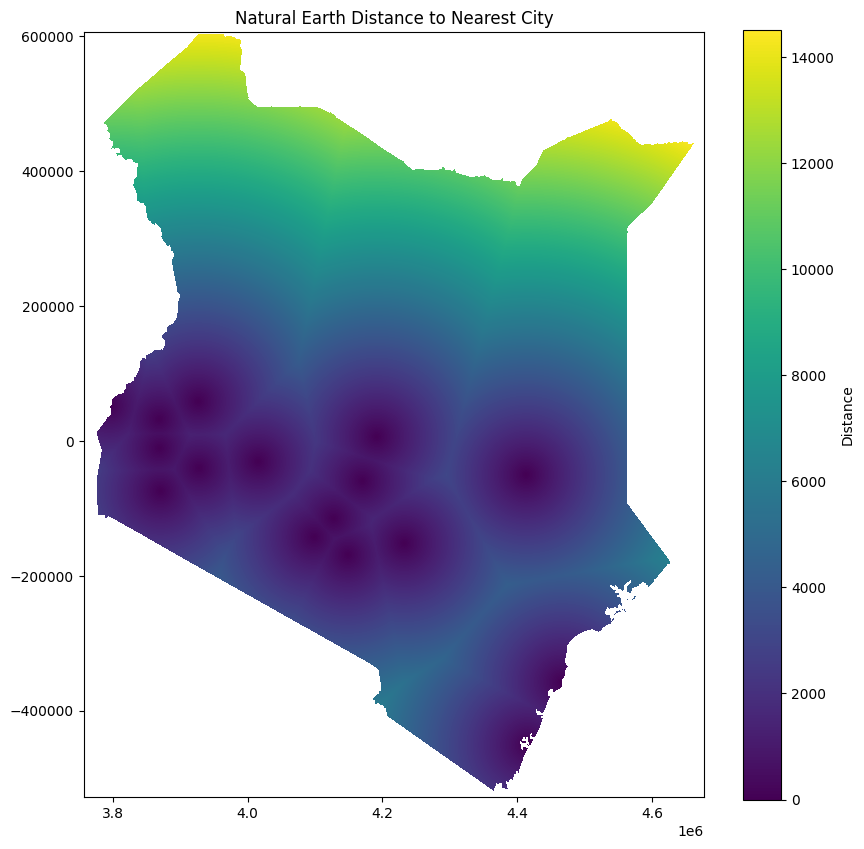

In [22]:
# Use Natural Earth Shape file as place holder
admin0_path = Path('/mnt/share/homes/mfiking/population/gis/population/kenya_admin_files/ken_admbnda_adm0_iebc_20191031.shp')

# Change the data type of the distance array to the same data type as out_meta
city_out = city_out.astype(out_meta['dtype'])

# Create path to store output
city_out_path = '/mnt/share/homes/mfiking/population/gis/population/distance_covariates/natural_earth/population_centers/city.tif'

# Generate meta data into out_path same meta data as out_meta
with rasterio.open(city_out_path, "w", **out_meta) as dest:
    dest.write(city_out.reshape((1, *city_out.shape)))


# Just overwrite the file we wrote
mask_admin(city_out_path, admin0_path, city_out_path)

# Read the combined raster
with rasterio.open(city_out_path) as src:
    combined_raster = src.read(1, masked=True)
    transform = src.transform
    crs = src.crs

# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(combined_raster, extent=(transform[2], transform[2] + transform[0]*combined_raster.shape[1],
                                   transform[5] + transform[4]*combined_raster.shape[0], transform[5]), cmap='viridis')

# Add a colorbar
cb = plt.colorbar()
cb.set_label('Distance')

# Set the title of the plot
plt.title('Natural Earth Distance to Nearest City')


plt.savefig('/mnt/share/homes/mfiking/population/gis/population/distance_covariates/natural_earth/population_centers/plots/city.jpg', dpi=300, bbox_inches='tight')

plt.show()


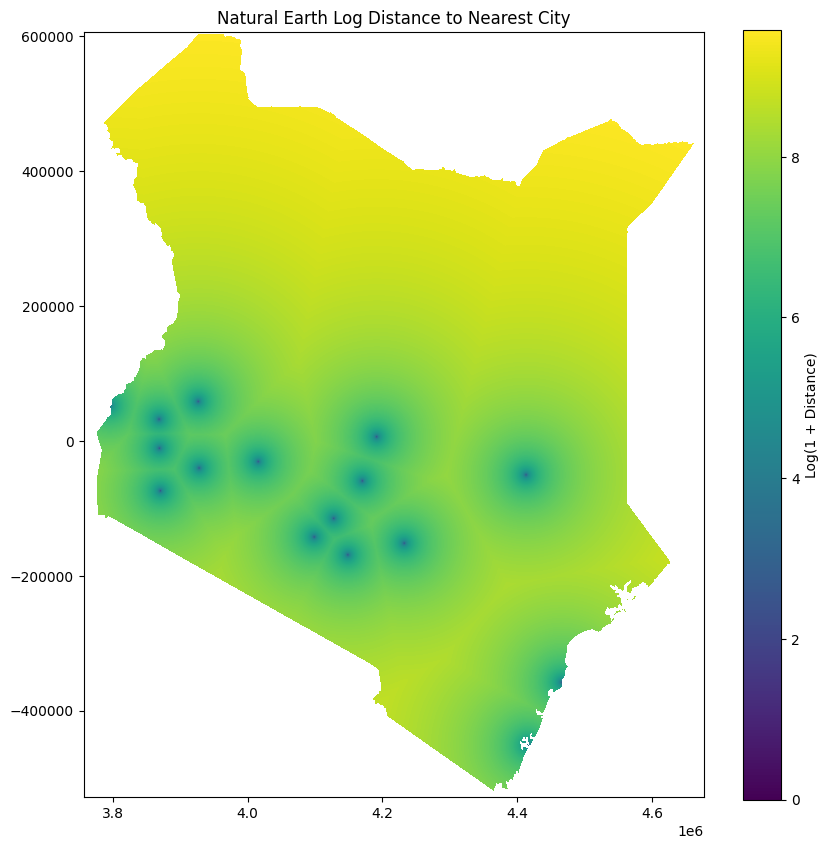

In [23]:
# Log Plot
with rasterio.open(city_out_path) as src:
    combined_raster = src.read(1, masked=True)
    transform = src.transform
    crs = src.crs
    
    # Apply the log transformation
    combined_raster = np.log(1 + combined_raster)
    
# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(combined_raster, extent=(transform[2], transform[2] + transform[0]*combined_raster.shape[1],
                                   transform[5] + transform[4]*combined_raster.shape[0], transform[5]), cmap='viridis')

# Add a colorbar
cb = plt.colorbar()
cb.set_label('Log(1 + Distance)')

# Set the title of the plot
plt.title('Natural Earth Log Distance to Nearest City')

plt.savefig('/mnt/share/homes/mfiking/population/gis/population/distance_covariates/natural_earth/population_centers/plots/log_city.jpg', dpi=300, bbox_inches='tight')

plt.show()


## Towns ##

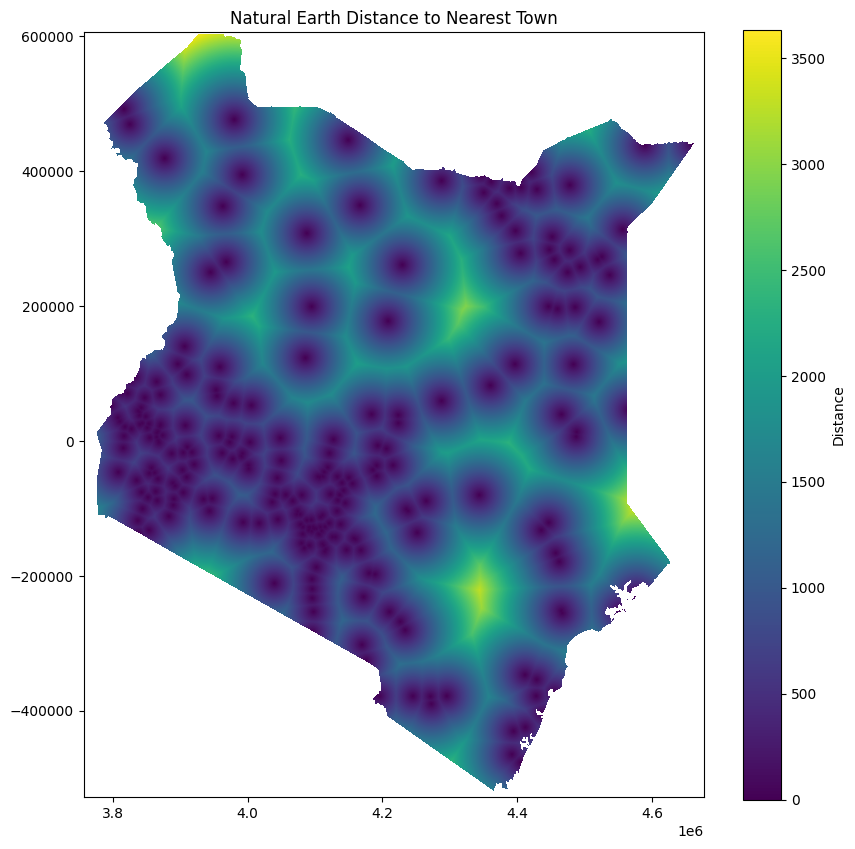

In [24]:
# Subset population center
town_gdf = population_data[population_data['place'].str.lower() == 'town']
# Get indices
town_raster, town_indices = rasterize_and_get_indices(town_gdf, kenya_shape, transform)

# Swap 0s and 1s
town_raster = np.logical_not(town_raster).astype(int)

# Compute distance
town_out = distance_transform_edt(town_raster)

# Use Natural Earth Shape file as place holder
admin0_path = Path('/mnt/share/homes/mfiking/population/gis/population/kenya_admin_files/ken_admbnda_adm0_iebc_20191031.shp')

# Change the data type of the distance array to the same data type as out_meta
town_out = town_out.astype(out_meta['dtype'])

# Create path to store output
town_out_path = '/mnt/share/homes/mfiking/population/gis/population/distance_covariates/natural_earth/population_centers/town.tif'

# Generate meta data into out_path same meta data as out_meta
with rasterio.open(town_out_path, "w", **out_meta) as dest:
    dest.write(town_out.reshape((1, *town_out.shape)))


# Just overwrite the file we wrote
mask_admin(town_out_path, admin0_path, town_out_path)

# Read the combined raster
with rasterio.open(town_out_path) as src:
    combined_raster = src.read(1, masked=True)
    transform = src.transform
    crs = src.crs

# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(combined_raster, extent=(transform[2], transform[2] + transform[0]*combined_raster.shape[1],
                                   transform[5] + transform[4]*combined_raster.shape[0], transform[5]), cmap='viridis')

# Add a colorbar
cb = plt.colorbar()
cb.set_label('Distance')

# Set the title of the plot
plt.title('Natural Earth Distance to Nearest Town')


plt.savefig('/mnt/share/homes/mfiking/population/gis/population/distance_covariates/natural_earth/population_centers/plots/town.jpg', dpi=300, bbox_inches='tight')

plt.show()


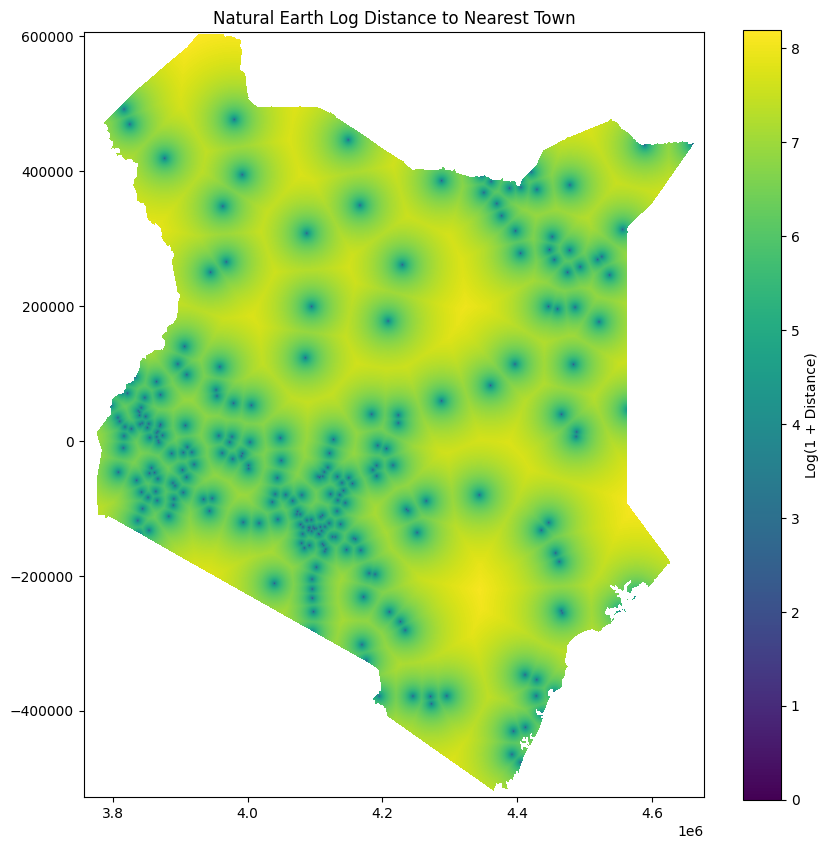

In [25]:
# Log Plot
with rasterio.open(town_out_path) as src:
    combined_raster = src.read(1, masked=True)
    transform = src.transform
    crs = src.crs
    
    # Apply the log transformation
    combined_raster = np.log(1 + combined_raster)
    
# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(combined_raster, extent=(transform[2], transform[2] + transform[0]*combined_raster.shape[1],
                                   transform[5] + transform[4]*combined_raster.shape[0], transform[5]), cmap='viridis')

# Add a colorbar
cb = plt.colorbar()
cb.set_label('Log(1 + Distance)')

# Set the title of the plot
plt.title('Natural Earth Log Distance to Nearest Town')

plt.savefig('/mnt/share/homes/mfiking/population/gis/population/distance_covariates/natural_earth/population_centers/plots/log_town.jpg', dpi=300, bbox_inches='tight')

plt.show()


## Villages ##

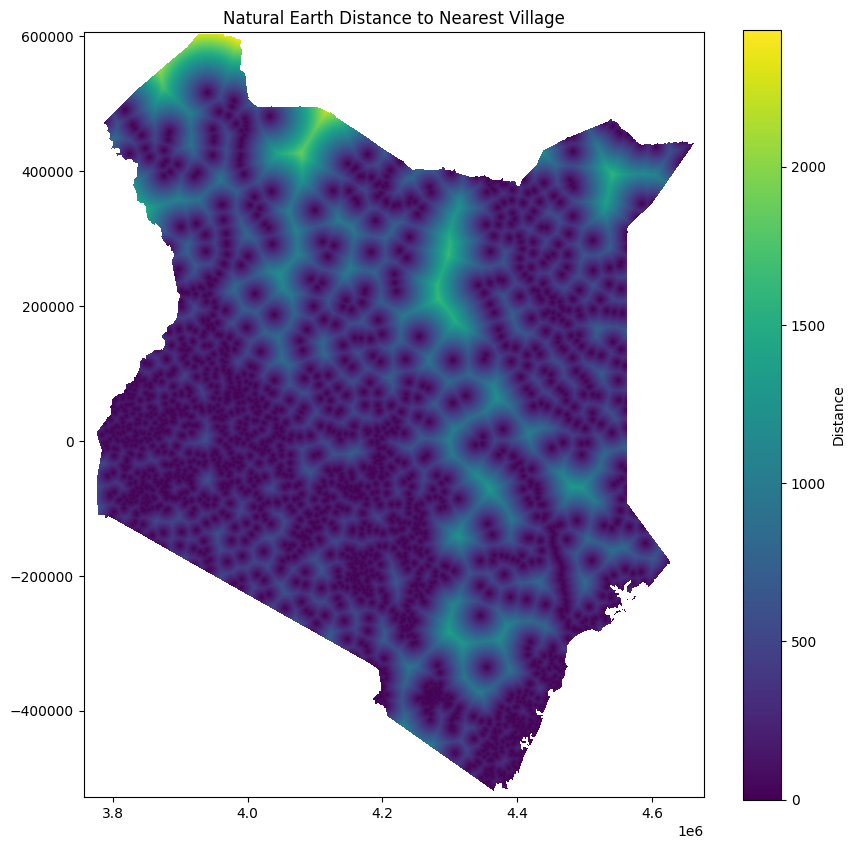

In [26]:
# Subset population center
village_gdf = population_data[population_data['place'].str.lower() == 'village']
# Get indices
village_raster, village_indices = rasterize_and_get_indices(village_gdf, kenya_shape, transform)

# Swap 0s and 1s
village_raster = np.logical_not(village_raster).astype(int)

# Compute distance
village_out = distance_transform_edt(village_raster)

# Use Natural Earth Shape file as place holder
admin0_path = Path('/mnt/share/homes/mfiking/population/gis/population/kenya_admin_files/ken_admbnda_adm0_iebc_20191031.shp')

# Change the data type of the distance array to the same data type as out_meta
village_out = village_out.astype(out_meta['dtype'])

# Create path to store output
village_out_path = '/mnt/share/homes/mfiking/population/gis/population/distance_covariates/natural_earth/population_centers/village.tif'

# Generate meta data into out_path same meta data as out_meta
with rasterio.open(village_out_path, "w", **out_meta) as dest:
    dest.write(village_out.reshape((1, *village_out.shape)))


# Just overwrite the file we wrote
mask_admin(village_out_path, admin0_path, village_out_path)

# Read the combined raster
with rasterio.open(village_out_path) as src:
    combined_raster = src.read(1, masked=True)
    transform = src.transform
    crs = src.crs

# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(combined_raster, extent=(transform[2], transform[2] + transform[0]*combined_raster.shape[1],
                                   transform[5] + transform[4]*combined_raster.shape[0], transform[5]), cmap='viridis')

# Add a colorbar
cb = plt.colorbar()
cb.set_label('Distance')

# Set the title of the plot
plt.title('Natural Earth Distance to Nearest Village')


plt.savefig('/mnt/share/homes/mfiking/population/gis/population/distance_covariates/natural_earth/population_centers/plots/village.jpg', dpi=300, bbox_inches='tight')

plt.show()


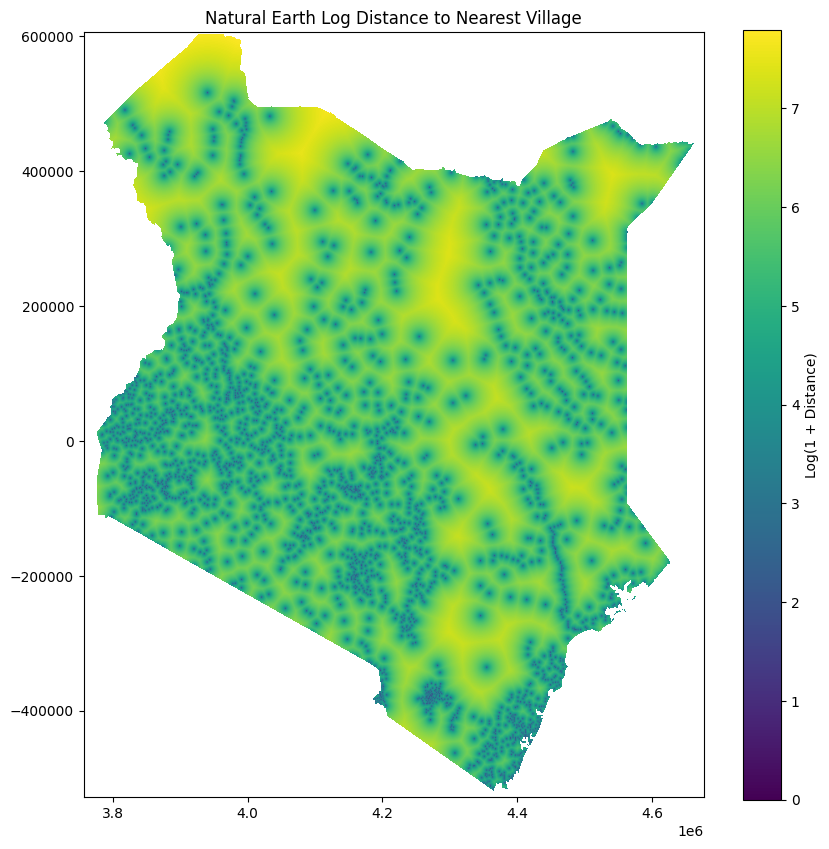

In [27]:
# Log Plot
with rasterio.open(village_out_path) as src:
    combined_raster = src.read(1, masked=True)
    transform = src.transform
    crs = src.crs
    
    # Apply the log transformation
    combined_raster = np.log(1 + combined_raster)
    
# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(combined_raster, extent=(transform[2], transform[2] + transform[0]*combined_raster.shape[1],
                                   transform[5] + transform[4]*combined_raster.shape[0], transform[5]), cmap='viridis')

# Add a colorbar
cb = plt.colorbar()
cb.set_label('Log(1 + Distance)')

# Set the title of the plot
plt.title('Natural Earth Log Distance to Nearest Village')

plt.savefig('/mnt/share/homes/mfiking/population/gis/population/distance_covariates/natural_earth/population_centers/plots/log_village.jpg', dpi=300, bbox_inches='tight')

plt.show()


## Hamlets ##

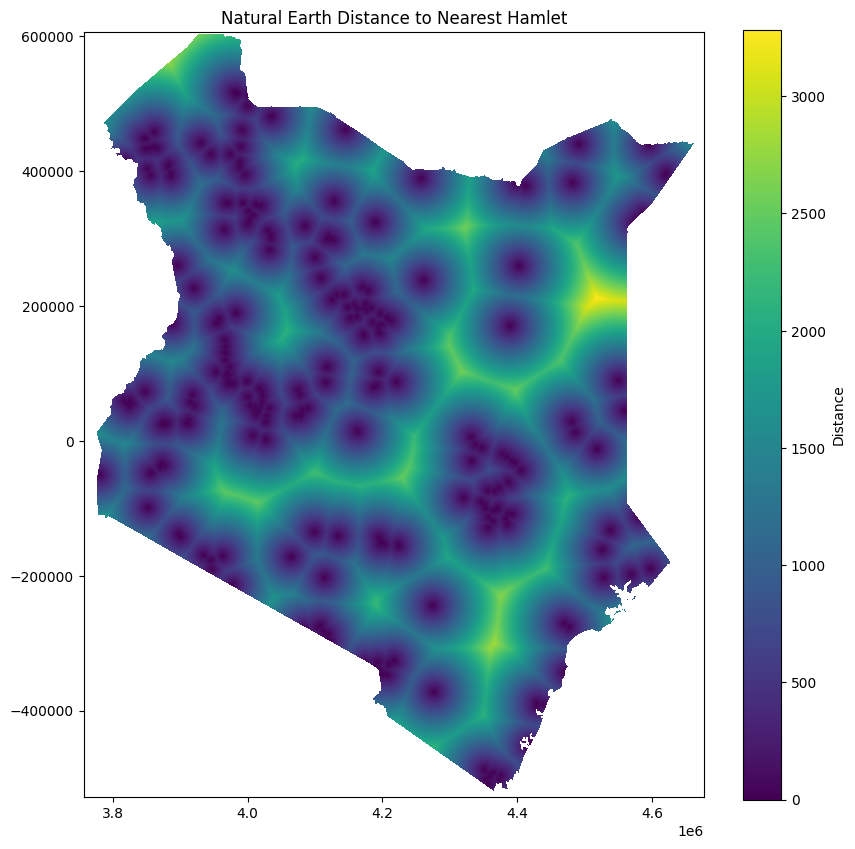

In [28]:
# Subset population center
hamlet_gdf = population_data[population_data['place'].str.lower() == 'hamlet']
# Get indices
hamlet_raster, hamlet_indices = rasterize_and_get_indices(hamlet_gdf, kenya_shape, transform)

# Swap 0s and 1s
hamlet_raster = np.logical_not(hamlet_raster).astype(int)

# Compute distance
hamlet_out = distance_transform_edt(hamlet_raster)

# Use Natural Earth Shape file as place holder
admin0_path = Path('/mnt/share/homes/mfiking/population/gis/population/kenya_admin_files/ken_admbnda_adm0_iebc_20191031.shp')

# Change the data type of the distance array to the same data type as out_meta
hamlet_out = hamlet_out.astype(out_meta['dtype'])

# Create path to store output
hamlet_out_path = '/mnt/share/homes/mfiking/population/gis/population/distance_covariates/natural_earth/population_centers/hamlet.tif'

# Generate meta data into out_path same meta data as out_meta
with rasterio.open(hamlet_out_path, "w", **out_meta) as dest:
    dest.write(hamlet_out.reshape((1, *hamlet_out.shape)))


# Just overwrite the file we wrote
mask_admin(hamlet_out_path, admin0_path, hamlet_out_path)

# Read the combined raster
with rasterio.open(hamlet_out_path) as src:
    combined_raster = src.read(1, masked=True)
    transform = src.transform
    crs = src.crs

# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(combined_raster, extent=(transform[2], transform[2] + transform[0]*combined_raster.shape[1],
                                   transform[5] + transform[4]*combined_raster.shape[0], transform[5]), cmap='viridis')

# Add a colorbar
cb = plt.colorbar()
cb.set_label('Distance')

# Set the title of the plot
plt.title('Natural Earth Distance to Nearest Hamlet')


plt.savefig('/mnt/share/homes/mfiking/population/gis/population/distance_covariates/natural_earth/population_centers/plots/hamlet.jpg', dpi=300, bbox_inches='tight')

plt.show()


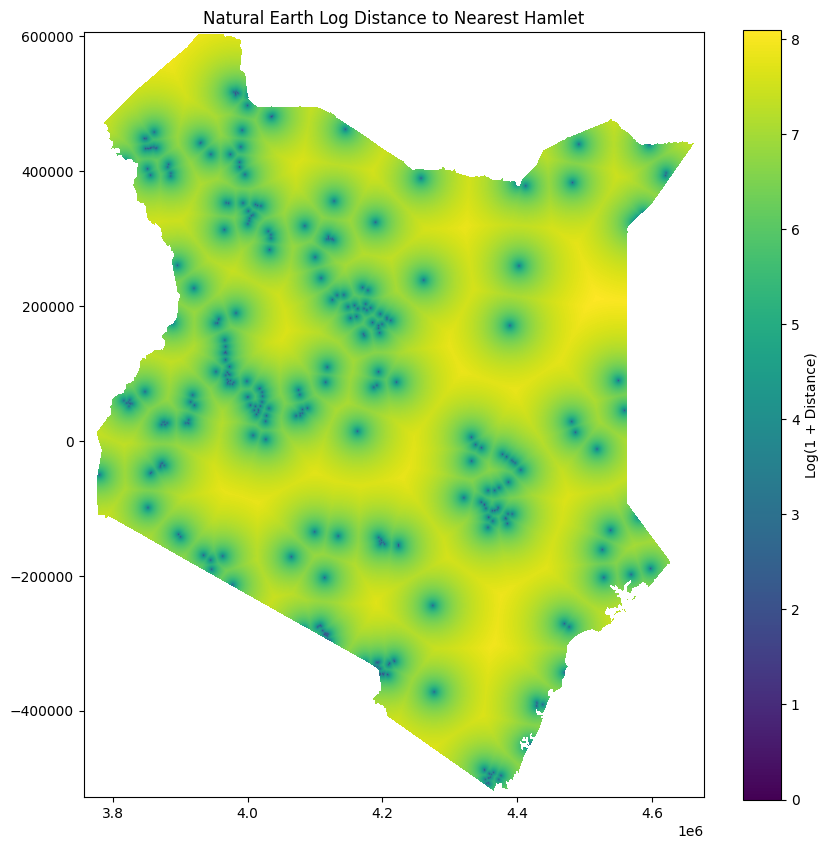

In [29]:
# Log Plot
with rasterio.open(hamlet_out_path) as src:
    combined_raster = src.read(1, masked=True)
    transform = src.transform
    crs = src.crs
    
    # Apply the log transformation
    combined_raster = np.log(1 + combined_raster)
    
# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(combined_raster, extent=(transform[2], transform[2] + transform[0]*combined_raster.shape[1],
                                   transform[5] + transform[4]*combined_raster.shape[0], transform[5]), cmap='viridis')

# Add a colorbar
cb = plt.colorbar()
cb.set_label('Log(1 + Distance)')

# Set the title of the plot
plt.title('Natural Earth Log Distance to Nearest Hamlet')

plt.savefig('/mnt/share/homes/mfiking/population/gis/population/distance_covariates/natural_earth/population_centers/plots/log_hamlet.jpg', dpi=300, bbox_inches='tight')

plt.show()


## Isolated Dwellings ##

In [ ]:
# Subset population center
isolated_dwelling_gdf = population_data[population_data['place'].str.lower() == 'isolated_dwelling']
# Get indices
iso_dwelling_raster, isolated_dwelling_indices = rasterize_and_get_indices(isolated_dwelling_gdf, kenya_shape, transform)

# Swap 0s and 1s
iso_dwelling_raster = np.logical_not(iso_dwelling_raster).astype(int)

# Compute distance
iso_dwelling_out = distance_transform_edt(iso_dwelling_raster)

# Use Natural Earth Shape file as place holder
admin0_path = Path('/mnt/share/homes/mfiking/population/gis/population/kenya_admin_files/ken_admbnda_adm0_iebc_20191031.shp')

# Change the data type of the distance array to the same data type as out_meta
isolated_dwelling_out = isolated_dwelling_out.astype(out_meta['dtype'])

# Create path to store output
isolated_dwelling_out_path = '/mnt/share/homes/mfiking/population/gis/population/distance_covariates/natural_earth/population_centers/isolated_dwelling.tif'

# Generate meta data into out_path same meta data as out_meta
with rasterio.open(isolated_dwelling_out_path, "w", **out_meta) as dest:
    dest.write(isolated_dwelling_out.reshape((1, *isolated_dwelling_out.shape)))


# Just overwrite the file we wrote
mask_admin(isolated_dwelling_out_path, admin0_path, isolated_dwelling_out_path)


In [ ]:
# Read the combined raster
with rasterio.open(isolated_dwelling_out_path) as src:
    combined_raster = src.read(1, masked=True)
    transform = src.transform
    crs = src.crs

# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(combined_raster, extent=(transform[2], transform[2] + transform[0]*combined_raster.shape[1],
                                   transform[5] + transform[4]*combined_raster.shape[0], transform[5]), cmap='viridis')

# Add a colorbar
cb = plt.colorbar()
cb.set_label('Distance')

# Set the title of the plot
plt.title('Natural Earth Distance to Nearest Isolated Dwelling')


plt.savefig('/mnt/share/homes/mfiking/population/gis/population/distance_covariates/natural_earth/population_centers/plots/isolated_dwelling.jpg', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
# Log Plot
with rasterio.open(isolated_dwelling_out_path) as src:
    combined_raster = src.read(1, masked=True)
    transform = src.transform
    crs = src.crs
    
    # Apply the log transformation
    combined_raster = np.log(1 + combined_raster)
    
# Plot the combined raster
plt.figure(figsize=(10, 10))
plt.imshow(combined_raster, extent=(transform[2], transform[2] + transform[0]*combined_raster.shape[1],
                                   transform[5] + transform[4]*combined_raster.shape[0], transform[5]), cmap='viridis')

# Add a colorbar
cb = plt.colorbar()
cb.set_label('Log(1 + Distance)')

# Set the title of the plot
plt.title('Natural Earth Log Distance to Nearest Isolated Dwelling')

plt.savefig('/mnt/share/homes/mfiking/population/gis/population/distance_covariates/natural_earth/population_centers/plots/log_isolated_dwelling.jpg', dpi=300, bbox_inches='tight')

plt.show()
